# Table of Content

<a name="outline"></a>

## Setup

- [A](#seca) External Imports
- [B](#secb) Internal Imports
- [C](#secc) Lazy Dictionary (Lazy Caching)
- [D](#secd) Configurations and Paths 
- [E](#sece) Patient Interface and Train/Val/Test Partitioning
- [F](#secf) General Utility Functions


## Evaluations

- [1](#sec1) Snooping/Selecting Best Models from the Validation Set
- [2](#sec2) Top-20 Detection Accuracy on MIMIC-III (Test Set)
- [3](#sec3) Top-20 Detection Accuracy on MIMIC-IV (Test Set)
- [4](#sec4) Relative AUC Performance on MIMIC-III (Test Set)
- [5](#sec5) Relative AUC Performance on MIMIC-IV (Test Set)
- [6](#sec6) Relative AUC Performance From MIMIC-III (Training Set) to MIMIC-IV (All)
- [7](#sec7) Relative AUC Performance From MIMIC-IV (Training Set) to MIMIC-III (All)

<a name="seca"></a>

### A External Imports [^](#outline)

In [1]:
import sys
import os
import glob
from collections import defaultdict

from IPython.display import display

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from upsetplot import from_contents, plot, UpSet, from_indicators


<a name="secb"></a>

### B Internal Imports [^](#outline)

In [2]:
sys.path.append('..')
HOME = os.environ.get('HOME')
from icenode.train_icenode_2lr import ICENODE
from icenode.train_icenode_uniform2lr import ICENODE as ICENODE_UNIFORM
from icenode.train_gram import GRAM
from icenode.train_retain import RETAIN
from icenode.metrics import codes_auc_pairwise_tests
from icenode.metrics import evaluation_table
from icenode.utils import write_params, load_config, load_params

%load_ext autoreload
%autoreload 2

/home/asem/anaconda3/envs/icenode/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


<a name="secc"></a>

### C Lazy Dictionary (Lazy Caching) [^](#outline)

In [3]:
class LazyDict(dict):
    def __getitem__(self, k):
        v = super().__getitem__(k)
        if callable(v):
            v = v()
            super().__setitem__(k, v)
        return v

    def get(self, k, default=None):
        if k in self:
            return self.__getitem__(k)
        return default

<a name="secd"></a>

### D Configurations and Paths [^](#outline)

In [83]:
mimic_dir = {
    'M3': f'{HOME}/GP/ehr-data/mimic3-transforms',
    'M4': f'{HOME}/GP/ehr-data/mimic4-transforms'
}

trained_dir = {
    'GM3': f'{HOME}/GP/ehr-data/icenode-m3-exp/train_config_v0.2.25_G_M3',
    'M3': f'{HOME}/GP/ehr-data/icenode-m3-exp/train_config_v0.2.25_M3',
    'M4': f'{HOME}/GP/ehr-data/icenode-m4-exp/train_config_v0.2.25_M4'
}

model_dir = {
    'ICE-NODE': 'icenode_2lr',
    'ICE-NODE_UNIFORM': 'icenode_uniform2lr',
    'GRU': 'gru',
    'RETAIN': 'retain'
}

model_cls = {
    'ICE-NODE': ICENODE,
    'ICE-NODE_UNIFORM': ICENODE_UNIFORM,
    'GRU': GRAM,
    'RETAIN': RETAIN
}   

clfs = list(model_dir.keys())

relative_auc_config = {
    'pvalue': 0.05, 
    'min_auc': 0.85
}

plt.rcParams["font.family"] = "Loma"#, "serif"


<a name="sece"></a>

### E Patient Interface and Train/Val/Test Patitioning [^](#outline)

In [5]:
def get_patient_interface(data_tag, clfs):
    interface_by_kind = LazyDict({
        'timestamped': lambda: ICENODE.create_patient_interface(mimic_dir[data_tag], data_tag),
        'sequential': lambda: GRAM.create_patient_interface(mimic_dir[data_tag], data_tag)
    })
    
    interface_kind = {
        'ICE-NODE':  'timestamped',
        'ICE-NODE_UNIFORM': 'timestamped',
        'GRU': 'sequential',
        'RETAIN': 'sequential'
    }

    return {clf: interface_by_kind[interface_kind[clf]] for clf in clfs}
    

m4_interface = get_patient_interface('M4', clfs)
m3_interface = get_patient_interface('M3', clfs)

m4_train_ids, m4_valid_ids, m4_test_ids = m4_interface[clfs[0]].random_splits(split1=0.7, split2=0.85, random_seed=42)
m3_train_ids, m3_valid_ids, m3_test_ids = m3_interface[clfs[0]].random_splits(split1=0.7, split2=0.85, random_seed=42)


In [6]:
m4_percentiles = m4_interface[clfs[0]].diag_flatccs_by_percentiles(20)
m3_percentiles = m3_interface[clfs[0]].diag_flatccs_by_percentiles(20)

m4_train_percentiles = m4_interface[clfs[0]].diag_flatccs_by_percentiles(20, m4_train_ids)
m3_train_percentiles = m3_interface[clfs[0]].diag_flatccs_by_percentiles(20, m3_train_ids)


<a name="secf"></a>

### F Utility Functions [^](#outline)

In [161]:

def performance_traces(data_tag, clfs):
    clfs_params_dir = trained_dir[data_tag]
    traces_df = {}
    for clf in clfs:
        clf_dir = model_dir[clf]
        csv_files =  glob.glob(f'{clfs_params_dir}/{clf_dir}/*.csv', recursive=False)
        dfs = [pd.read_csv(csv_file, index_col=[0]) for csv_file in csv_files]
        df = pd.concat([df[["VAL"]].transpose() for df in dfs]).reset_index()
        df = df[['loss', 'accuracy']]        
        traces_df[clf] = df

    return traces_df

def get_trained_models(train_dir, clfs, criterion, comp):
    params = {}
    config = {}
    df = {}
    clfs_params_dir = trained_dir[train_dir]
    
    best_iter, best_val = [], []
    for clf in clfs:
        clf_dir = model_dir[clf]
        csv_files =  glob.glob(f'{clfs_params_dir}/{clf_dir}/*.csv', recursive=False)
        dfs = [pd.read_csv(csv_file, index_col=[0]) for csv_file in csv_files]
        max_i = comp(range(len(dfs)), key=lambda i: dfs[i].loc[criterion, 'VAL'].sum())
        
        best_iter.append(max_i)
        best_val.append(dfs[max_i].loc[criterion, "VAL"].sum())
        
        df[clf] = dfs[max_i]        
        csv_file = csv_files[max_i]
        prefix = csv_file.split('_')
        prefix[-1] = 'params.pickle'
        params_file = '_'.join(prefix)
        params[clf] = load_params(params_file)
        config[clf] = load_config(f'{clfs_params_dir}/{clf_dir}/config.json')
        
    display(pd.DataFrame({'Clf': clfs, 'Best_i': best_iter, str(criterion): best_val}))
    return config, params, df


    
def eval_(model, ids):
    model, state = model
    return model.eval(state, ids)['diag_detectability']

def eval2_(model, ids):
    model, state = model
    return model.eval(state, ids)

def test_eval_table(dfs, metric):
    data = {}
    clfs = dfs.keys()
    for clf, df in dfs.items():
        data[clf] = df.loc[metric, "TST"].tolist()
    return pd.DataFrame(data=data, index=metric).transpose()

def get_model(clf, config, params, interface):
    model = model_cls[clf].create_model(config, interface, [], None)
    state = model.init_with_params(config, params)
    return model, state
        
def get_models(clfs, config, params, interface):
    return {clf: get_model(clf, config[clf], params[clf], interface[clf]) for clf in clfs}


def cross_predictor(clf, source_tag, target_tag):   
    if '/G' in clf:
        _m3_params = gm3_params
        _m3_config = gm3_config
        
        clf = clf.replace('/G','')
    else:
        _m3_params = m3_params
        _m3_config = m3_config

    if source_tag == 'M3':
        params = _m3_params[clf]
        config = _m3_config[clf]
    else:
        params = m4_params[clf]
        config = m4_config[clf]
        
    if target_tag == 'M3':
        target_interface = m3_interface[clf]
    else:
        target_interface = m4_interface[clf]
        
    
    return get_model(clf, config, params, target_interface)
            
    
def selected_auc_barplot(clfs, auctest_df):
    auc_df = []

    for clf in clfs:
        comp_auc = auctest_df[f'AUC({clf})']
        comp_var = auctest_df[f'VAR[AUC({clf})]']
        comp_std = comp_var.apply(np.sqrt)
        comp_desc = auctest_df['DESC'].apply(lambda t: t if len(t) < 15 else t.replace(' ', '\n'))
        df = pd.DataFrame({'AUC': comp_auc, 'std': comp_std, 'CCS': comp_desc, 'Classifier': clf})
        auc_df.append(df)
    auc_df = pd.concat(auc_df)
    vals = auc_df.pivot(index='CCS', columns='Classifier', values='AUC')
    err = auc_df.pivot(index='CCS', columns='Classifier', values='std')
    # plot vals with yerr
    ax = vals.plot.bar(xerr=err, rot=0, figsize=(10, 10), width=0.7,
                   error_kw=dict(lw=5, capsize=8, capthick=5, ecolor='salmon'),
                  color=[ 'black', 'white', 'green'], edgecolor='black')

    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(6)  # change width
        ax.spines[axis].set_color('red')    # change color




    plt.xlabel('AUC', fontsize=32)
    min_auc_tick = int(auc_df['AUC'].min() * 20)/20

    plt.xticks(fontsize=24)    
    plt.xlim(min_auc_tick, 1.0)
    
    xstart, xend = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(xstart, xend+0.01, 0.05))

    plt.yticks(fontsize=24)

    plt.ylabel('CCS', fontsize=32)
    ax.tick_params(bottom=True, left=False)
    
    
    # Add hatches
    bars = ax.patches
    patterns =('.', 'x', 'O','o','/','-', '+','O','o','\\','\\\\')
    hatches = [p for p in patterns for i in range(len(df))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
    
    ax.grid(True)
    _ = ax.legend(title='Classifier', loc='upper right', 
                  fontsize=20, title_fontsize=32)
    return ax

def make_clf_paris(clfs):
    clfs_pairs = []
    for i in range(len(clfs)):
        for j in range(i + 1, len(clfs)):
            clfs_pairs.append((clfs[i], clfs[j]))
    return tuple(sorted(clfs_pairs))
    
def relative_performance_upset(auc_tests, selected_clfs, patient_interface, pvalue, min_auc):
    flatccs_idx2code = {idx: code for code, idx in patient_interface.diag_flatccs_idx.items()}
    idx2desc = lambda i: patient_interface.dag.diag_flatccs_desc[flatccs_idx2code[i]]
    auc_tests['DESC'] = auc_tests['CODE_INDEX'].apply(idx2desc)
    
    # remove codes that no classifier has scored above 0.7
    accepted_aucs = auc_tests.loc[:,[f'AUC({clf})' for clf in selected_clfs]].max(axis=1) > min_auc
    print(f'{len(accepted_aucs)} codes predicted an AUC higher than {min_auc} by at least one model.')
    tests = auc_tests[accepted_aucs]
    tests = tests.fillna(1)
    test_cols = [col for col in tests.columns if col[:2] == 'P0']
    
    common_perf = tests[tests.loc[:,test_cols].min(axis=1) > pvalue]
    auc_sets = defaultdict(set)
    clfs = tuple(sorted(selected_clfs))
    auc_sets[clfs] = set(common_perf.CODE_INDEX)
    competing_tests = tests.drop(index=common_perf.index)

    clfs_pairs = make_clf_paris(clfs)

    for index, row in competing_tests.iterrows():
        max_auc_clf = max(clfs, key=lambda clf: row[f'AUC({clf})'])
        insignificant_diff = {(clf1, clf2): f'P0(AUC_{clf1}==AUC_{clf2})' for (clf1, clf2) in clfs_pairs \
                          if max_auc_clf in (clf1, clf2) and row[f'P0(AUC_{clf1}==AUC_{clf2})'] > pvalue}

        if len(insignificant_diff) == 0:
            auc_sets[max_auc_clf].add(int(row['CODE_INDEX']))
        else:
            for (clf1, clf2), test_col in insignificant_diff.items():
                auc_sets[(clf1, clf2)].add(int(row['CODE_INDEX']))            
            
    # Prepare for using Upset plot -> Set Layout (passed to `from_contents`)
    content_sets = {}
    for clf in clfs:
        content_sets[clf] = auc_sets[clf] | auc_sets[clfs]
        for clf1, clf2 in clfs_pairs:
            if clf in (clf1, clf2):
                content_sets[clf].update(auc_sets[(clf1, clf2)])
    
    # Prepare for using Upset plot -> DataFrame Layout (passed to `from_indicators`)
    code_index = tests.CODE_INDEX.tolist()
    competence_assignments = {}
    for clf in clfs:
        competence_assignments[clf] = [c in content_sets[clf] for c in code_index]
    indicator_df = pd.DataFrame(competence_assignments, index=code_index)
    
    # Descriptive statistics for each code.    
    avg_aucs, n_codes = [], []
    for c in code_index:
        competent_clfs = [clf for clf in clfs if indicator_df.loc[c, clf]]
        avg_auc = tests.loc[c, list(f'AUC({clf})' for clf in competent_clfs)].mean()
        avg_aucs.append(avg_auc)
        n_codes.append(tests.loc[c, 'N_POSITIVE_CODES'])
    data = pd.DataFrame({'Avg. AUC': avg_aucs, '#positive cases': n_codes}, index=code_index)    
    return content_sets, indicator_df, data, common_perf, competing_tests


<a name="sec1"></a>

## 1 Snooping/Selecting Best Models from the Validation Set [^](#outline)

In [9]:
# Classifiers with Linear Embeddings
clfs = (
    'ICE-NODE', 
    'ICE-NODE_UNIFORM',
    'GRU',
    'RETAIN'
)


# Classifiers with GRAM Embeddings
clfsG = (
    'ICE-NODE', 
    'ICE-NODE_UNIFORM',
    'GRU'
)

print('> Models trained on MIMIC-IV')
m4_config_minloss, m4_params_minloss, m4_df_minloss = get_trained_models('M4', clfs, 'loss', comp=min)
m4_config_maxauc, m4_params_maxauc, m4_df_maxauc = get_trained_models('M4', clfs, 'MICRO-AUC', comp=max)

print('> Models trained on MIMIC-III')
m3_config_minloss, m3_params_minloss, m3_df_minloss = get_trained_models('M3', clfs, 'loss', comp=min)
m3_config_maxauc, m3_params_maxauc, m3_df_maxauc = get_trained_models('M3', clfs, 'MICRO-AUC', comp=max)


print('> Models (GRAM) trained on MIMIC-III')
m3_config_minlossG, m3_params_minlossG, m3_df_minlossG = get_trained_models('GM3', clfsG, 'loss', comp=min)
m3_config_maxaucG, m3_params_maxaucG, m3_df_maxaucG = get_trained_models('GM3', clfsG, 'MICRO-AUC', comp=max)


> Models trained on MIMIC-IV


,Clf,Best_i,loss
0,ICE-NODE,40,0.000735
1,ICE-NODE_UNIFORM,25,0.000744
2,GRU,72,31.025291
3,RETAIN,20,31.072317


,Clf,Best_i,MICRO-AUC
0,ICE-NODE,87,0.933961
1,ICE-NODE_UNIFORM,91,0.932462
2,GRU,72,0.936528
3,RETAIN,24,0.936482


> Models trained on MIMIC-III


,Clf,Best_i,loss
0,ICE-NODE,19,0.000797
1,ICE-NODE_UNIFORM,19,0.000797
2,GRU,99,38.797390
3,RETAIN,47,38.536705


,Clf,Best_i,MICRO-AUC
0,ICE-NODE,45,0.925790
1,ICE-NODE_UNIFORM,11,0.925757
2,GRU,14,0.923570
3,RETAIN,42,0.927307


> Models (GRAM) trained on MIMIC-III


,Clf,Best_i,loss
0,ICE-NODE,0,0.000808
1,ICE-NODE_UNIFORM,0,0.000808
2,GRU,56,38.865055


,Clf,Best_i,MICRO-AUC
0,ICE-NODE,81,0.924722
1,ICE-NODE_UNIFORM,82,0.924760
2,GRU,14,0.923149


In [10]:
m4_models_minloss = get_models(clfs, m4_config_minloss, m4_params_minloss, m4_interface)
m4_models_maxauc = get_models(clfs, m4_config_maxauc, m4_params_maxauc, m4_interface)

m3_models_minloss = get_models(clfs, m3_config_minloss, m3_params_minloss, m3_interface)
m3_models_maxauc = get_models(clfs, m3_config_maxauc, m3_params_maxauc, m3_interface)

m3_models_minlossG = get_models(clfsG, m3_config_minlossG, m3_params_minlossG, m3_interface)
m3_models_maxaucG = get_models(clfsG, m3_config_maxaucG, m3_params_maxaucG, m3_interface)

### Snooping on MIMIC-III Validation Set

In [10]:
m3_val_res_minloss = {clf: eval_(model, m3_valid_ids) for clf, model in m3_models_minloss.items()} 
m3_val_res_maxauc = {clf: eval_(model, m3_valid_ids) for clf, model in m3_models_maxauc.items()} 

m3_val_res_minlossG = {clf: eval_(model, m3_valid_ids) for clf, model in m3_models_minlossG.items()} 
m3_val_res_maxaucG = {clf: eval_(model, m3_valid_ids) for clf, model in m3_models_maxaucG.items()} 


m3_val_auctests_minloss = codes_auc_pairwise_tests(m3_val_res_minloss, fast=True)
m3_val_auctests_maxauc = codes_auc_pairwise_tests(m3_val_res_maxauc, fast=True)
m3_val_auctests_minlossG = codes_auc_pairwise_tests(m3_val_res_minlossG, fast=True)
m3_val_auctests_maxaucG = codes_auc_pairwise_tests(m3_val_res_maxaucG, fast=True)


m3_val_res_all = {**{f'{k}_loss': v for k, v in m3_val_res_minloss.items()},
               **{f'{k}_uAUC': v for k, v in m3_val_res_maxauc.items()}}

m3_val_res_allG = {**{f'{k}_loss': v for k, v in m3_val_res_minlossG.items()},
               **{f'{k}_uAUC': v for k, v in m3_val_res_maxaucG.items()}}

  0%|                                                                                                                                                                                      | 0/242 [00:00<?, ?it/s]/home/asem/GP/ICENODE/analysis/../icenode/delong.py:203: RuntimeWarning: invalid value encountered in true_divide
  z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [00:01<00:00, 152.09it/s]


In [11]:
m3_val_auctests_all = codes_auc_pairwise_tests(m3_val_res_all, fast=True)
m3_val_auctests_allG = codes_auc_pairwise_tests(m3_val_res_allG, fast=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [00:07<00:00, 30.74it/s]


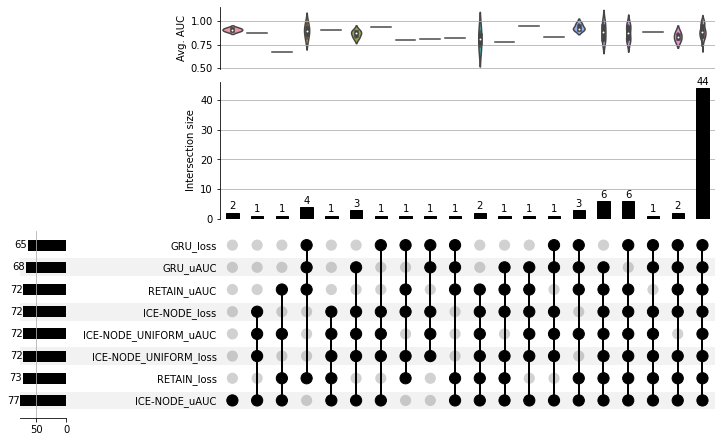

In [13]:

selected_clfs = tuple(sorted(m3_val_res_all.keys()))
content_set, indicator_df, data, common_codes, dichotomous_codes = relative_performance_upset(m3_val_auctests_all, selected_clfs, m3_interface[clfs[0]], **relative_auc_config)
upset_format = from_indicators(indicator_df, data=data)
upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
upset_object.add_catplot(value='Avg. AUC', kind="violin")
upset_object.plot()
plt.show()

### Snooping on MIMIC-IV Validation Set

In [14]:
m4_val_res_minloss = {clf: eval_(model, m4_valid_ids) for clf, model in m4_models_minloss.items()} 
m4_val_res_maxauc = {clf: eval_(model, m4_valid_ids) for clf, model in m4_models_maxauc.items()} 

m4_val_auctests_minloss = codes_auc_pairwise_tests(m4_val_res_minloss, fast=True)
m4_val_auctests_maxauc = codes_auc_pairwise_tests(m4_val_res_maxauc, fast=True)

m4_val_res_all = {**{f'{k}_loss': v for k, v in m4_val_res_minloss.items()},
                  **{f'{k}_uAUC': v for k, v in m4_val_res_maxauc.items()}}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [01:49<00:00,  2.21it/s]


In [15]:
m4_val_auctests_all = codes_auc_pairwise_tests(m4_val_res_all, fast=True)

  0%|                                                                                                                                                                               | 0/242 [00:00<?, ?it/s]/home/asem/GP/ICENODE/analysis/../icenode/delong.py:203: RuntimeWarning: invalid value encountered in true_divide
  z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [08:30<00:00,  2.11s/it]


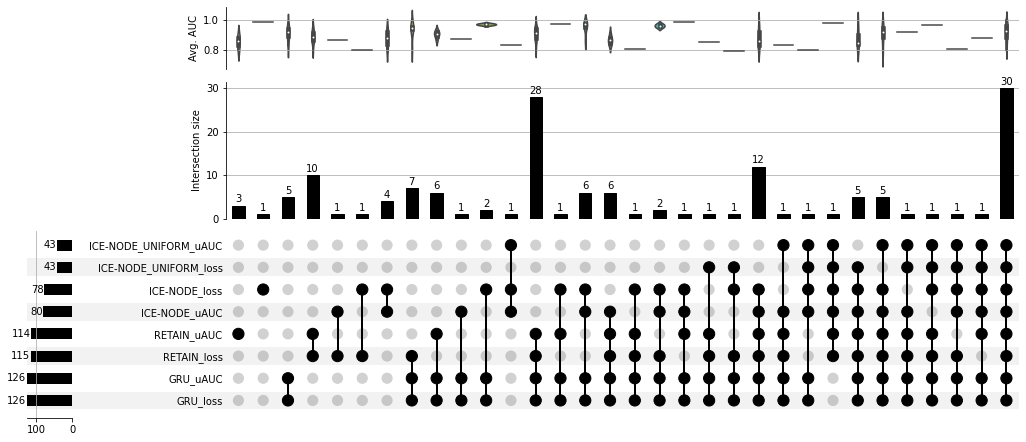

In [16]:
selected_clfs = tuple(sorted(m4_val_res_all.keys()))
content_set, indicator_df, data, common_codes, dichotomous_codes = relative_performance_upset(m4_val_auctests_all, selected_clfs, m4_interface[clfs[0]], **relative_auc_config)
upset_format = from_indicators(indicator_df, data=data)
upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
upset_object.add_catplot(value='Avg. AUC', kind="violin")
upset_object.plot()
plt.show()

### Snooping Conclusion

In the cells above, we evaluate the model competency by the number of codes
predicted competently compared to the other models.
It is realized that for `GRU`, `RETAIN`, and `ICENODE_UNIFORM`, the competency is maximized by picking the
model with minimum validation loss throughout the training iterations.
However, `ICENODE` competency is maximized by picking the model with maximum average validation AUC throughout the training iterations. Therefore, subsequent evaluations will consider only the most competent models on the validation set, as we select in the next cell.

In [11]:
m4_config = {}
m4_params = {}
m4_eval = {}

m3_config = {}
m3_params = {}
m3_eval = {}

gm3_config = {}
gm3_params = {}
gm3_eval = {}

selection_dicts = (m4_config, m4_params, m4_eval, 
                   m3_config, m3_params, m3_eval, 
                   gm3_config, gm3_params, gm3_eval)

maxauc_dicts = (m4_config_maxauc, m4_params_maxauc, m4_df_maxauc,
                m3_config_maxauc, m3_params_maxauc, m3_df_maxauc,
                m3_config_maxaucG, m3_params_maxaucG, m3_df_maxaucG)

minloss_dicts = (m4_config_minloss, m4_params_minloss, m4_df_minloss,
                 m3_config_minloss, m3_params_minloss, m3_df_minloss,
                 m3_config_minlossG, m3_params_minlossG, m3_df_minlossG)

for clf in ('GRU', 'RETAIN', 'ICE-NODE', 'ICE-NODE_UNIFORM'):
    
    if clf == 'ICE-NODE':
        best_dicts = maxauc_dicts
    else:
        best_dicts = minloss_dicts
        
    for dict_a, dict_b in zip(selection_dicts, best_dicts):
        if clf in dict_b:
            dict_a[clf] = dict_b[clf]

<a name="sec2"></a>

## 2 Top-20 Detection Accuracy on MIMIC-III (Test Set) [^](#outline)

In [12]:


def styled_df(df):  
    import numpy as np
    pd.set_option('precision', 3)
    def highlight_max(s, props=''):
        return np.where(s == np.nanmax(s.values), props, '')
    
    s_df = df.style
    s_df = s_df.apply(highlight_max, props='bfseries: ;color:white;background-color:darkblue', axis=0)
    texttt = [{'selector': 'th', 'props': 'font-family: monospace;'}]

    latex_str = s_df.to_latex(convert_css=True)
    for clf in df.index.tolist():
        latex_str = latex_str.replace(clf, f'\\texttt{{{clf}}}', 1)
    latex_str = latex_str.replace('_', '\\_')
    return s_df, latex_str

In [71]:
# Pick the best models results from max_auc and min_loss snapshots on the validation data.



df_acc20_dict = {
    **{clf: m3_eval[clf] for clf in ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')},
    **{f'{clf}/G': gm3_eval[clf] for clf in ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU')},
}

df_acc20 = test_eval_table(df_acc20_dict, list(f'ACC-P{i}' for i in range(5)))
df_acc20 = df_acc20.apply(lambda x: round(x, 3))
df_acc20.to_csv(f'acc20_mimic3.csv')

s_df, ltx_s = styled_df(df_acc20)
display(s_df)
print(ltx_s)

,ACC-P0,ACC-P1,ACC-P2,ACC-P3,ACC-P4
ICE-NODE,0.265,0.504,0.675,0.854,0.943
ICE-NODE_UNIFORM,0.230,0.496,0.691,0.859,0.958
GRU,0.212,0.481,0.673,0.870,0.964
RETAIN,0.238,0.499,0.690,0.877,0.973
ICE-NODE/G,0.244,0.501,0.673,0.858,0.944
ICE-NODE_UNIFORM/G,0.217,0.493,0.674,0.867,0.955
GRU/G,0.224,0.483,0.677,0.863,0.959


\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & \color{white} {\cellcolor{darkblue}} 0.265 & \color{white} {\cellcolor{darkblue}} 0.504 & 0.675 & 0.854 & 0.943 \\
\texttt{ICE-NODE\_UNIFORM} & 0.230 & 0.496 & \color{white} {\cellcolor{darkblue}} 0.691 & 0.859 & 0.958 \\
\texttt{GRU} & 0.212 & 0.481 & 0.673 & 0.870 & 0.964 \\
\texttt{RETAIN} & 0.238 & 0.499 & 0.690 & \color{white} {\cellcolor{darkblue}} 0.877 & \color{white} {\cellcolor{darkblue}} 0.973 \\
\texttt{ICE-NODE/G} & 0.244 & 0.501 & 0.673 & 0.858 & 0.944 \\
\texttt{ICE-NODE\_UNIFORM/G} & 0.217 & 0.493 & 0.674 & 0.867 & 0.955 \\
\texttt{GRU/G} & 0.224 & 0.483 & 0.677 & 0.863 & 0.959 \\
\end{tabular}



<a name="sec3"></a>

## 3 Top-20 Detection Accuracy on MIMIC-IV (Test Set) [^](#outline)

In [14]:
# Pick the best models results from max_auc and min_loss snapshots on the validation data.
df_acc20 = {
    clf: m4_eval[clf] for clf in ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')
}

df_acc20 = test_eval_table(df_acc20, list(f'ACC-P{i}' for i in range(5)))
df_acc20 = df_acc20.apply(lambda x: round(x, 3))
df_acc20.to_csv(f'acc20_mimic4.csv')

s_df, ltx_s = styled_df(df_acc20)
display(s_df)
print(ltx_s)

,ACC-P0,ACC-P1,ACC-P2,ACC-P3,ACC-P4
ICE-NODE,0.406,0.548,0.704,0.869,0.942
ICE-NODE_UNIFORM,0.401,0.540,0.691,0.870,0.946
GRU,0.396,0.558,0.733,0.896,0.950
RETAIN,0.393,0.541,0.725,0.903,0.962


\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & \color{white} {\cellcolor{darkblue}} 0.406 & 0.548 & 0.704 & 0.869 & 0.942 \\
\texttt{ICE-NODE\_UNIFORM} & 0.401 & 0.540 & 0.691 & 0.870 & 0.946 \\
\texttt{GRU} & 0.396 & \color{white} {\cellcolor{darkblue}} 0.558 & \color{white} {\cellcolor{darkblue}} 0.733 & 0.896 & 0.950 \\
\texttt{RETAIN} & 0.393 & 0.541 & 0.725 & \color{white} {\cellcolor{darkblue}} 0.903 & \color{white} {\cellcolor{darkblue}} 0.962 \\
\end{tabular}



<a name="sec4"></a>

## 4 Relative AUC Performance on MIMIC-III (Test Set) [^](#outline)

In [15]:

m3_clfs =  ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN',
           'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')
m3_predictors = {clf: cross_predictor(clf, 'M3', 'M3') for clf in m3_clfs}
test_res_m3 = {clf: eval2_(model, m3_test_ids) for clf, model in m3_predictors.items()} 

In [16]:
auctests_m3 = codes_auc_pairwise_tests({k: v['diag_detectability'] for k, v in test_res_m3.items()}, fast=True)


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 132/242 [00:06<00:04, 22.04it/s]/home/asem/GP/ICENODE/analysis/../icenode/delong.py:203: RuntimeWarning: invalid value encountered in true_divide
  z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|

183 codes predicted an AUC higher than 0.85 by at least one model.


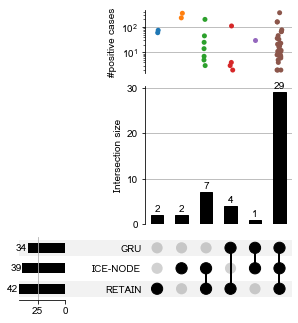

In [80]:
upset_clfs = ('ICE-NODE',  'GRU', 'RETAIN')

upsetcontents_m3, upsetindicator_m3, data_m3,  _, compete_codesm3 = relative_performance_upset(auctests_m3, upset_clfs, m3_interface[clfs[0]], **relative_auc_config)
upset_format = from_indicators(upsetindicator_m3, data=data_m3)
upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
# upset_object.add_catplot(value='Avg. AUC', kind="strip")
upset_object.add_catplot(value='#positive cases', kind="strip")
g = upset_object.plot()
g['extra1'].set_yscale('log')

current_figure = plt.gcf()
current_figure.savefig(f"upset_M3.pdf")

In [43]:
results_m3_k5, _ = evaluation_table(test_res_m3, m3_train_percentiles, top_k=5)


In [18]:
results_m3_k10, _ = evaluation_table(test_res_m3, m3_train_percentiles, top_k=10)
results_m3_k15, _ = evaluation_table(test_res_m3, m3_train_percentiles, top_k=15)


/home/asem/anaconda3/envs/icenode/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5338: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


In [44]:

df_acc5 = results_m3_k5.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc5 = df_acc5.apply(lambda x: round(x, 3))
df_acc5.to_csv(f'acc5_mimic3.csv')
s_df, ltx_s = styled_df(df_acc5)
display(s_df)
print(ltx_s)

,ACC-P0,ACC-P1,ACC-P2,ACC-P3,ACC-P4
ICE-NODE,0.104,0.226,0.268,0.337,0.601
ICE-NODE_UNIFORM,0.084,0.199,0.249,0.342,0.647
GRU,0.090,0.216,0.257,0.361,0.575
RETAIN,0.103,0.226,0.273,0.316,0.597
ICE-NODE/G,0.102,0.219,0.262,0.339,0.604
ICE-NODE_UNIFORM/G,0.088,0.205,0.237,0.339,0.628
GRU/G,0.097,0.224,0.262,0.323,0.593


\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & \color{white} {\cellcolor{darkblue}} 0.104 & \color{white} {\cellcolor{darkblue}} 0.226 & 0.268 & 0.337 & 0.601 \\
\texttt{ICE-NODE\_UNIFORM} & 0.084 & 0.199 & 0.249 & 0.342 & \color{white} {\cellcolor{darkblue}} 0.647 \\
\texttt{GRU} & 0.090 & 0.216 & 0.257 & \color{white} {\cellcolor{darkblue}} 0.361 & 0.575 \\
\texttt{RETAIN} & 0.103 & \color{white} {\cellcolor{darkblue}} 0.226 & \color{white} {\cellcolor{darkblue}} 0.273 & 0.316 & 0.597 \\
\texttt{ICE-NODE/G} & 0.102 & 0.219 & 0.262 & 0.339 & 0.604 \\
\texttt{ICE-NODE\_UNIFORM/G} & 0.088 & 0.205 & 0.237 & 0.339 & 0.628 \\
\texttt{GRU/G} & 0.097 & 0.224 & 0.262 & 0.323 & 0.593 \\
\end{tabular}



In [19]:

df_acc10 = results_m3_k10.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc10 = df_acc10.apply(lambda x: round(x, 3))
df_acc10.to_csv(f'acc10_mimic3.csv')
s_df, ltx_s = styled_df(df_acc10)
display(s_df)
print(ltx_s)

,ACC-P0,ACC-P1,ACC-P2,ACC-P3,ACC-P4
ICE-NODE,0.175,0.342,0.442,0.627,0.811
ICE-NODE_UNIFORM,0.130,0.320,0.434,0.633,0.843
GRU,0.137,0.313,0.433,0.625,0.816
RETAIN,0.159,0.331,0.440,0.605,0.837
ICE-NODE/G,0.159,0.334,0.436,0.618,0.813
ICE-NODE_UNIFORM/G,0.137,0.320,0.422,0.623,0.837
GRU/G,0.144,0.327,0.426,0.602,0.824


\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & \color{white} {\cellcolor{darkblue}} 0.175 & \color{white} {\cellcolor{darkblue}} 0.342 & \color{white} {\cellcolor{darkblue}} 0.442 & 0.627 & 0.811 \\
\texttt{ICE-NODE\_UNIFORM} & 0.130 & 0.320 & 0.434 & \color{white} {\cellcolor{darkblue}} 0.633 & \color{white} {\cellcolor{darkblue}} 0.843 \\
\texttt{GRU} & 0.137 & 0.313 & 0.433 & 0.625 & 0.816 \\
\texttt{RETAIN} & 0.159 & 0.331 & 0.440 & 0.605 & 0.837 \\
\texttt{ICE-NODE/G} & 0.159 & 0.334 & 0.436 & 0.618 & 0.813 \\
\texttt{ICE-NODE\_UNIFORM/G} & 0.137 & 0.320 & 0.422 & 0.623 & 0.837 \\
\texttt{GRU/G} & 0.144 & 0.327 & 0.426 & 0.602 & 0.824 \\
\end{tabular}



In [20]:

df_acc15 = results_m3_k15.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc15 = df_acc15.apply(lambda x: round(x, 3))
df_acc15.to_csv(f'acc15_mimic3.csv')
s_df, ltx_s = styled_df(df_acc15)
display(s_df)
print(ltx_s)

,ACC-P0,ACC-P1,ACC-P2,ACC-P3,ACC-P4
ICE-NODE,0.220,0.425,0.578,0.782,0.902
ICE-NODE_UNIFORM,0.175,0.407,0.581,0.788,0.928
GRU,0.178,0.401,0.564,0.786,0.924
RETAIN,0.199,0.417,0.575,0.778,0.934
ICE-NODE/G,0.205,0.421,0.569,0.782,0.907
ICE-NODE_UNIFORM/G,0.181,0.404,0.568,0.788,0.919
GRU/G,0.185,0.402,0.561,0.771,0.919


\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & \color{white} {\cellcolor{darkblue}} 0.220 & \color{white} {\cellcolor{darkblue}} 0.425 & 0.578 & 0.782 & 0.902 \\
\texttt{ICE-NODE\_UNIFORM} & 0.175 & 0.407 & \color{white} {\cellcolor{darkblue}} 0.581 & \color{white} {\cellcolor{darkblue}} 0.788 & 0.928 \\
\texttt{GRU} & 0.178 & 0.401 & 0.564 & 0.786 & 0.924 \\
\texttt{RETAIN} & 0.199 & 0.417 & 0.575 & 0.778 & \color{white} {\cellcolor{darkblue}} 0.934 \\
\texttt{ICE-NODE/G} & 0.205 & 0.421 & 0.569 & 0.782 & 0.907 \\
\texttt{ICE-NODE\_UNIFORM/G} & 0.181 & 0.404 & 0.568 & \color{white} {\cellcolor{darkblue}} 0.788 & 0.919 \\
\texttt{GRU/G} & 0.185 & 0.402 & 0.561 & 0.771 & 0.919 \\
\end{tabular}



In [170]:
icenode_m3_excl = upsetcontents_m3['ICE-NODE'] - set.union(*list(upsetcontents_m3[clf] for clf in ('RETAIN', 'GRU')))
icenode_m3_excl = compete_codesm3[compete_codesm3['CODE_INDEX'].isin(icenode_m3_excl)]
icenode_m3_excl

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(GRU/G),AUC(ICE-NODE),AUC(ICE-NODE/G),AUC(ICE-NODE_UNIFORM),AUC(ICE-NODE_UNIFORM/G),AUC(RETAIN),VAR[AUC(GRU)],...,P0(AUC_ICE-NODE==AUC_ICE-NODE_UNIFORM),P0(AUC_ICE-NODE==AUC_ICE-NODE_UNIFORM/G),P0(AUC_ICE-NODE==AUC_RETAIN),P0(AUC_ICE-NODE/G==AUC_ICE-NODE_UNIFORM),P0(AUC_ICE-NODE/G==AUC_ICE-NODE_UNIFORM/G),P0(AUC_ICE-NODE/G==AUC_RETAIN),P0(AUC_ICE-NODE_UNIFORM==AUC_ICE-NODE_UNIFORM/G),P0(AUC_ICE-NODE_UNIFORM==AUC_RETAIN),P0(AUC_ICE-NODE_UNIFORM/G==AUC_RETAIN),DESC
10,10,353.0,0.843,0.84,0.858,0.851,0.859,0.852,0.836,1.656e-04,...,0.890,0.085,0.003,0.012,0.644,0.051,0.018,0.003,0.043,Cardia arrst
60,60,232.0,0.873,0.87,0.894,0.882,0.881,0.881,0.875,1.807e-04,...,0.018,0.034,0.020,0.767,0.513,0.315,0.853,0.378,0.413,GI hemorrhag


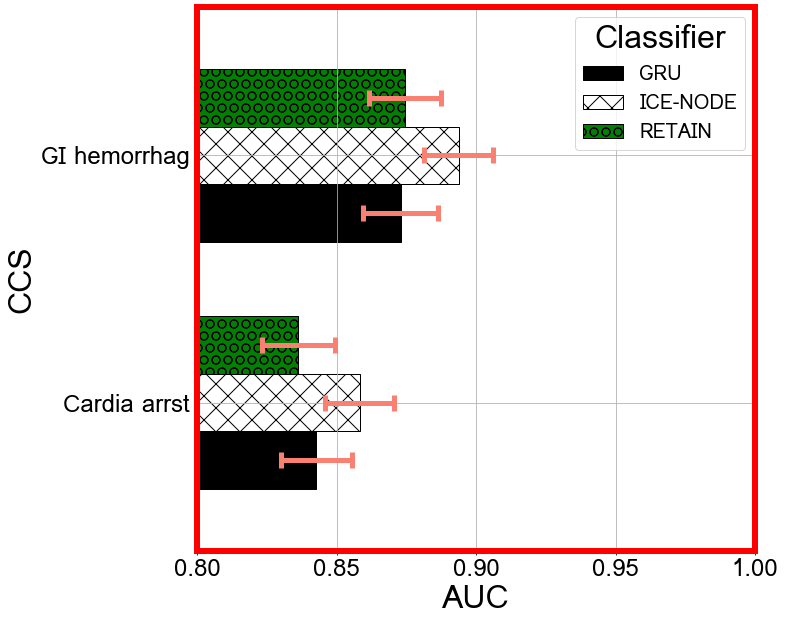

In [171]:
ax = selected_auc_barplot(upset_clfs, icenode_m3_excl)
current_figure = plt.gcf()
current_figure.savefig("icenode_m3.pdf", bbox_inches='tight')
plt.show()


<a name="sec5"></a>

## 5 Relative AUC Performance on MIMIC-IV (Test Set) [^](#outline)

In [21]:
relauc_clfs =  ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')
m4_predictors = {clf: cross_predictor(clf, 'M4', 'M4') for clf in relauc_clfs}
test_res_m4 = {clf: eval2_(model, m4_test_ids) for clf, model in m4_predictors.items()} 

In [22]:
auctests_m4 = codes_auc_pairwise_tests({k: v['diag_detectability'] for k, v in test_res_m4.items()}, fast=True)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [01:45<00:00,  2.29it/s]


237 codes predicted an AUC higher than 0.85 by at least one model.


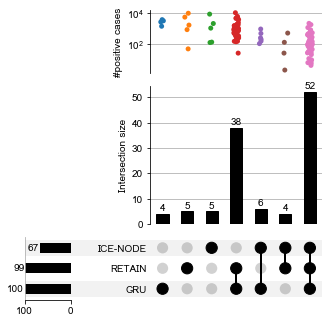

In [81]:
upset_clfs = ('ICE-NODE', 'GRU', 'RETAIN')

upsetcontents_m4, upsetindicator_m4, data_m4,  _, compete_codesm4 = relative_performance_upset(auctests_m4, upset_clfs, m4_interface[clfs[0]], **relative_auc_config)
upset_format = from_indicators(upsetindicator_m4, data=data_m4)
upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
# upset_object.add_catplot(value='Avg. AUC', kind="strip")
upset_object.add_catplot(value='#positive cases', kind="strip")

g = upset_object.plot()
g['extra1'].set_yscale('log')

current_figure = plt.gcf()
current_figure.savefig(f"upset_M4.pdf")

In [24]:
icenode_m4_excl = upsetcontents_m4['ICE-NODE'] - set.union(*list(upsetcontents_m4[clf] for clf in ('RETAIN', 'GRU')))
icenode_m4_excl = compete_codesm4[compete_codesm4['CODE_INDEX'].isin(icenode_m4_excl)]
icenode_m4_excl

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICE-NODE),AUC(ICE-NODE_UNIFORM),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICE-NODE)],VAR[AUC(ICE-NODE_UNIFORM)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICE-NODE),P0(AUC_GRU==AUC_ICE-NODE_UNIFORM),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICE-NODE==AUC_ICE-NODE_UNIFORM),P0(AUC_ICE-NODE==AUC_RETAIN),P0(AUC_ICE-NODE_UNIFORM==AUC_RETAIN),DESC
6,6,2063.0,0.899,0.917,0.891,0.899,1.418e-05,1.142e-05,1.602e-05,1.421e-05,3.490e-11,1.883e-04,0.635,5.524e-26,1.866e-10,5.499e-05,Pulm hart dx
36,36,1172.0,0.805,0.823,0.803,0.806,4.702e-05,4.067e-05,4.894e-05,4.709e-05,7.125e-05,6.612e-01,0.775,1.763e-12,1.505e-04,5.050e-01,Pleurisy
94,94,129.0,0.959,0.969,0.959,0.961,4.874e-05,2.003e-05,3.719e-05,3.667e-05,8.231e-03,9.462e-01,0.557,1.571e-04,2.015e-03,2.903e-01,Early labor
105,105,1040.0,0.981,0.984,0.978,0.980,1.920e-06,1.291e-06,2.186e-06,2.204e-06,2.341e-05,1.467e-03,0.086,1.396e-08,5.630e-07,8.187e-02,Forceps del
212,212,305.0,0.797,0.844,0.796,0.792,1.748e-04,1.054e-04,1.883e-04,1.797e-04,4.107e-05,9.257e-01,0.396,4.384e-07,6.469e-06,6.269e-01,Alcohol-related disorders
236,236,8394.0,0.888,0.912,0.885,0.889,4.589e-06,3.617e-06,5.062e-06,4.599e-06,4.705e-48,1.745e-02,0.302,3.273e-91,1.236e-44,1.757e-03,Other ear dx


In [25]:
selected_icenode_m4_excl = set(list(icenode_m4_excl))

In [41]:
results_m4_k5, _ = evaluation_table(test_res_m4, m4_train_percentiles, top_k=5)


In [26]:
results_m4_k10, _ = evaluation_table(test_res_m4, m4_train_percentiles, top_k=10)
results_m4_k15, _ = evaluation_table(test_res_m4, m4_train_percentiles, top_k=15)

In [42]:

df_acc5 = results_m4_k5.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc5 = df_acc10.apply(lambda x: round(x, 3))
df_acc5.to_csv(f'acc5_mimic4.csv')
s_df, ltx_s = styled_df(df_acc5)
display(s_df)
print(ltx_s)

,ACC-P0,ACC-P1,ACC-P2,ACC-P3,ACC-P4
ICE-NODE,0.311,0.316,0.459,0.627,0.811
ICE-NODE_UNIFORM,0.308,0.312,0.451,0.625,0.813
GRU,0.282,0.310,0.475,0.672,0.818
RETAIN,0.298,0.309,0.475,0.663,0.809


\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & \color{white} {\cellcolor{darkblue}} 0.311 & \color{white} {\cellcolor{darkblue}} 0.316 & 0.459 & 0.627 & 0.811 \\
\texttt{ICE-NODE\_UNIFORM} & 0.308 & 0.312 & 0.451 & 0.625 & 0.813 \\
\texttt{GRU} & 0.282 & 0.310 & \color{white} {\cellcolor{darkblue}} 0.475 & \color{white} {\cellcolor{darkblue}} 0.672 & \color{white} {\cellcolor{darkblue}} 0.818 \\
\texttt{RETAIN} & 0.298 & 0.309 & \color{white} {\cellcolor{darkblue}} 0.475 & 0.663 & 0.809 \\
\end{tabular}



In [27]:

df_acc10 = results_m4_k10.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc10 = df_acc10.apply(lambda x: round(x, 3))
df_acc10.to_csv(f'acc10_mimic4.csv')
s_df, ltx_s = styled_df(df_acc10)
display(s_df)
print(ltx_s)

,ACC-P0,ACC-P1,ACC-P2,ACC-P3,ACC-P4
ICE-NODE,0.327,0.421,0.478,0.615,0.832
ICE-NODE_UNIFORM,0.320,0.415,0.469,0.611,0.832
GRU,0.300,0.411,0.500,0.652,0.849
RETAIN,0.308,0.404,0.493,0.651,0.851


\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & \color{white} {\cellcolor{darkblue}} 0.327 & \color{white} {\cellcolor{darkblue}} 0.421 & 0.478 & 0.615 & 0.832 \\
\texttt{ICE-NODE\_UNIFORM} & 0.320 & 0.415 & 0.469 & 0.611 & 0.832 \\
\texttt{GRU} & 0.300 & 0.411 & \color{white} {\cellcolor{darkblue}} 0.500 & \color{white} {\cellcolor{darkblue}} 0.652 & 0.849 \\
\texttt{RETAIN} & 0.308 & 0.404 & 0.493 & 0.651 & \color{white} {\cellcolor{darkblue}} 0.851 \\
\end{tabular}



In [28]:

df_acc15 = results_m4_k15.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc15 = df_acc15.apply(lambda x: round(x, 3))
df_acc15.to_csv(f'acc15_mimic4.csv')
s_df, ltx_s = styled_df(df_acc15)
display(s_df)
print(ltx_s)

,ACC-P0,ACC-P1,ACC-P2,ACC-P3,ACC-P4
ICE-NODE,0.375,0.493,0.605,0.774,0.904
ICE-NODE_UNIFORM,0.370,0.485,0.593,0.773,0.906
GRU,0.355,0.491,0.633,0.808,0.917
RETAIN,0.357,0.478,0.621,0.815,0.927


\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & \color{white} {\cellcolor{darkblue}} 0.375 & \color{white} {\cellcolor{darkblue}} 0.493 & 0.605 & 0.774 & 0.904 \\
\texttt{ICE-NODE\_UNIFORM} & 0.370 & 0.485 & 0.593 & 0.773 & 0.906 \\
\texttt{GRU} & 0.355 & 0.491 & \color{white} {\cellcolor{darkblue}} 0.633 & 0.808 & 0.917 \\
\texttt{RETAIN} & 0.357 & 0.478 & 0.621 & \color{white} {\cellcolor{darkblue}} 0.815 & \color{white} {\cellcolor{darkblue}} 0.927 \\
\end{tabular}



In [168]:
icenode_m4_excl = upsetcontents_m4['ICE-NODE'] - set.union(*list(upsetcontents_m4[clf] for clf in ('RETAIN', 'GRU')))
icenode_m4_excl = compete_codesm4[compete_codesm4['CODE_INDEX'].isin(icenode_m4_excl)]
icenode_m4_excl

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICE-NODE),AUC(ICE-NODE_UNIFORM),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICE-NODE)],VAR[AUC(ICE-NODE_UNIFORM)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICE-NODE),P0(AUC_GRU==AUC_ICE-NODE_UNIFORM),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICE-NODE==AUC_ICE-NODE_UNIFORM),P0(AUC_ICE-NODE==AUC_RETAIN),P0(AUC_ICE-NODE_UNIFORM==AUC_RETAIN),DESC
6,6,2063.0,0.899,0.917,0.891,0.899,1.418e-05,1.142e-05,1.602e-05,1.421e-05,3.490e-11,1.883e-04,0.635,5.524e-26,1.866e-10,5.499e-05,Pulm hart dx
79,79,121.0,0.881,0.898,0.881,0.878,1.965e-04,1.860e-04,2.236e-04,2.360e-04,4.942e-02,9.796e-01,0.591,1.582e-03,8.425e-03,7.159e-01,Prolapse
94,94,129.0,0.959,0.969,0.959,0.961,4.874e-05,2.003e-05,3.719e-05,3.667e-05,8.231e-03,9.462e-01,0.557,1.571e-04,2.015e-03,2.903e-01,Early labor
105,105,1040.0,0.981,0.984,0.978,0.980,1.920e-06,1.291e-06,2.186e-06,2.204e-06,2.341e-05,1.467e-03,0.086,1.396e-08,5.630e-07,8.187e-02,Forceps del
236,236,8394.0,0.888,0.912,0.885,0.889,4.589e-06,3.617e-06,5.062e-06,4.599e-06,4.705e-48,1.745e-02,0.302,3.273e-91,1.236e-44,1.757e-03,Other ear dx


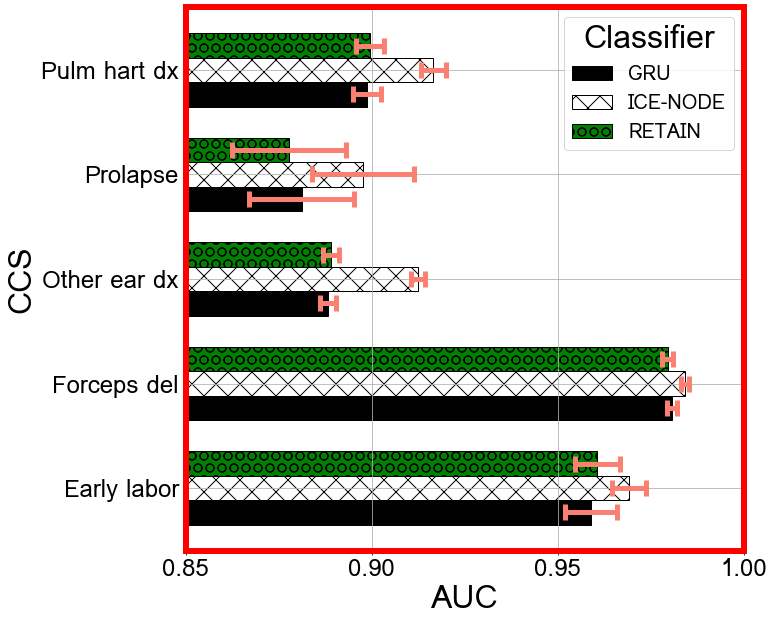

In [169]:
ax = selected_auc_barplot(upset_clfs, icenode_m4_excl)
current_figure = plt.gcf()
current_figure.savefig("icenode_m4.pdf", bbox_inches='tight')
plt.show()


<a name="sec6"></a>

## 6 Relative AUC Performance From MIMIC-III (Training Set) to MIMIC-IV (All) [^](#outline)
 

In [ ]:
# clfs_ordered = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')
# m3_percentiles = m3_interface[clfs[0]].diag_flatccs_by_percentiles(20)

# m4_subjects = list(m4_interface[clfs[0]].subjects.keys())
# m3m4_predictors = {clf: cross_predictor(clf, 'M3', 'M4') for clf in clfs_ordered}


In [ ]:
# test_res_m3m4 = {clf: eval2_(model, m4_subjects) for clf, model in m3m4_predictors.items()} 
# results_m3m4, _ = evaluation_table(test_res_m3m4, m3_percentiles, top_k=20)


In [ ]:
# def test_eval_table(df, metric):
#     df = df.loc[metric, clfs_ordered]
#     return df.transpose()

# m3m4_acc20 = test_eval_table(results_m3m4, list(f'ACC-P{i}' for i in range(5)))
# m3m4_acc20.to_csv(f'm3m4_acc20.csv')
# print(m3m4_acc20.apply(lambda x: round(x, 3)).style.highlight_max(axis=0, props='bfseries: ;').to_latex())  

In [ ]:
# auctests_m3m4 = codes_auc_pairwise_tests({k: v['diag_detectability'] for k, v in test_res_m3m4.items()}, fast=True)


In [ ]:
# sets_m3m4, upsetm3m4_df, _, compete_codesm3m4 = relative_performance_upset(auctests_m3m4, upset_clfs, m4_interface[clfs[0]], **relative_auc_config)
# upset_contents_m3m4 = from_contents(sets_m3m4)


In [ ]:
# UpSet(upset_contents_m4m3, subset_size='count', show_counts=True).plot()
# current_figure = plt.gcf()
# current_figure.savefig(f"upset_contents_M4M3.pdf")


<a name="sec7"></a>

## 7 Relative AUC Performance From MIMIC-IV (Training Set) to MIMIC-III (All) [^](#outline)

In [29]:
clfs_ordered = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')
m3_subjects = list(m3_interface[clfs[0]].subjects.keys())
m4m3_predictors = {clf: cross_predictor(clf, 'M4', 'M3') for clf in clfs_ordered}

In [30]:
test_res_m4m3 = {clf: eval2_(model, m3_subjects) for clf, model in m4m3_predictors.items()} 

In [31]:
auctests_m4m3 = codes_auc_pairwise_tests({k: v['diag_detectability'] for k, v in test_res_m4m3.items()}, fast=True)

 37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                   | 90/242 [00:08<00:06, 22.89it/s]/home/asem/GP/ICENODE/analysis/../icenode/delong.py:203: RuntimeWarning: invalid value encountered in true_divide
  z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|

215 codes predicted an AUC higher than 0.85 by at least one model.


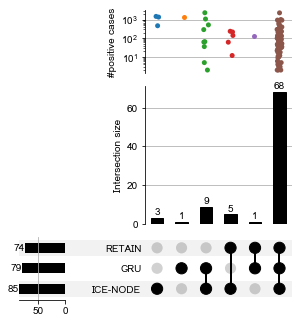

In [165]:
upset_clfs = ('ICE-NODE', 'GRU', 'RETAIN')
upsetcontents_m4m3, upsetindicator_m4m3, data_m4m3,  _, compete_codesm4m3 = relative_performance_upset(auctests_m4m3, upset_clfs, m4_interface[clfs[0]], **relative_auc_config)
upset_format = from_indicators(upsetindicator_m4m3, data=data_m4m3)
upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
# upset_object.add_catplot(value='Avg. AUC', kind="strip")
upset_object.add_catplot(value='#positive cases', kind="strip")
g = upset_object.plot()
g['extra1'].set_yscale('log')

current_figure = plt.gcf()
current_figure.savefig(f"upset_M4M3.pdf")

In [39]:
results_m4m3_k5, _ = evaluation_table(test_res_m4m3, m4_train_percentiles, top_k=5)


In [33]:
results_m4m3_k10, _ = evaluation_table(test_res_m4m3, m4_train_percentiles, top_k=10)
results_m4m3_k15, _ = evaluation_table(test_res_m4m3, m4_train_percentiles, top_k=15)

In [40]:
df_acc5 = results_m4m3_k5.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc5 = df_acc5.apply(lambda x: round(x, 3))
df_acc5.to_csv(f'acc5_m4m3.csv')
s_df, ltx_s = styled_df(df_acc5)
display(s_df)
print(ltx_s)

,ACC-P0,ACC-P1,ACC-P2,ACC-P3,ACC-P4
ICE-NODE,0.216,0.203,0.275,0.391,0.596
ICE-NODE_UNIFORM,0.209,0.201,0.274,0.391,0.604
GRU,0.200,0.199,0.296,0.405,0.609
RETAIN,0.215,0.203,0.292,0.404,0.579


\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & \color{white} {\cellcolor{darkblue}} 0.216 & \color{white} {\cellcolor{darkblue}} 0.203 & 0.275 & 0.391 & 0.596 \\
\texttt{ICE-NODE\_UNIFORM} & 0.209 & 0.201 & 0.274 & 0.391 & 0.604 \\
\texttt{GRU} & 0.200 & 0.199 & \color{white} {\cellcolor{darkblue}} 0.296 & \color{white} {\cellcolor{darkblue}} 0.405 & \color{white} {\cellcolor{darkblue}} 0.609 \\
\texttt{RETAIN} & 0.215 & \color{white} {\cellcolor{darkblue}} 0.203 & 0.292 & 0.404 & 0.579 \\
\end{tabular}



In [34]:
df_acc10 = results_m4m3_k10.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc10 = df_acc10.apply(lambda x: round(x, 3))
df_acc10.to_csv(f'acc10_m4m3.csv')
s_df, ltx_s = styled_df(df_acc10)
display(s_df)
print(ltx_s)

,ACC-P0,ACC-P1,ACC-P2,ACC-P3,ACC-P4
ICE-NODE,0.311,0.316,0.459,0.627,0.811
ICE-NODE_UNIFORM,0.308,0.312,0.451,0.625,0.813
GRU,0.282,0.310,0.475,0.672,0.818
RETAIN,0.298,0.309,0.475,0.663,0.809


\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & \color{white} {\cellcolor{darkblue}} 0.311 & \color{white} {\cellcolor{darkblue}} 0.316 & 0.459 & 0.627 & 0.811 \\
\texttt{ICE-NODE\_UNIFORM} & 0.308 & 0.312 & 0.451 & 0.625 & 0.813 \\
\texttt{GRU} & 0.282 & 0.310 & \color{white} {\cellcolor{darkblue}} 0.475 & \color{white} {\cellcolor{darkblue}} 0.672 & \color{white} {\cellcolor{darkblue}} 0.818 \\
\texttt{RETAIN} & 0.298 & 0.309 & \color{white} {\cellcolor{darkblue}} 0.475 & 0.663 & 0.809 \\
\end{tabular}



In [35]:
df_acc15 = results_m4m3_k15.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc15 = df_acc15.apply(lambda x: round(x, 3))
df_acc15.to_csv(f'acc15_m4m3.csv')
s_df, ltx_s = styled_df(df_acc15)
display(s_df)
print(ltx_s)

,ACC-P0,ACC-P1,ACC-P2,ACC-P3,ACC-P4
ICE-NODE,0.361,0.389,0.584,0.780,0.894
ICE-NODE_UNIFORM,0.357,0.383,0.575,0.781,0.897
GRU,0.332,0.392,0.610,0.819,0.896
RETAIN,0.345,0.384,0.602,0.813,0.899


\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & \color{white} {\cellcolor{darkblue}} 0.361 & 0.389 & 0.584 & 0.780 & 0.894 \\
\texttt{ICE-NODE\_UNIFORM} & 0.357 & 0.383 & 0.575 & 0.781 & 0.897 \\
\texttt{GRU} & 0.332 & \color{white} {\cellcolor{darkblue}} 0.392 & \color{white} {\cellcolor{darkblue}} 0.610 & \color{white} {\cellcolor{darkblue}} 0.819 & 0.896 \\
\texttt{RETAIN} & 0.345 & 0.384 & 0.602 & 0.813 & \color{white} {\cellcolor{darkblue}} 0.899 \\
\end{tabular}



In [166]:
icenode_m4m3_excl = upsetcontents_m4m3['ICE-NODE'] - set.union(*list(upsetcontents_m4m3[clf] for clf in ('RETAIN', 'GRU')))
icenode_m4m3_excl = compete_codesm4m3[compete_codesm4m3['CODE_INDEX'].isin(icenode_m4m3_excl)]
icenode_m4m3_excl

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICE-NODE),AUC(ICE-NODE_UNIFORM),AUC(RETAIN),VAR[AUC(GRU)],VAR[AUC(ICE-NODE)],VAR[AUC(ICE-NODE_UNIFORM)],VAR[AUC(RETAIN)],P0(AUC_GRU==AUC_ICE-NODE),P0(AUC_GRU==AUC_ICE-NODE_UNIFORM),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICE-NODE==AUC_ICE-NODE_UNIFORM),P0(AUC_ICE-NODE==AUC_RETAIN),P0(AUC_ICE-NODE_UNIFORM==AUC_RETAIN),DESC
64,64,1489.0,0.899,0.912,0.896,0.888,2.250e-05,1.822e-05,2.299e-05,2.590e-05,3.937e-07,0.166,1.062e-08,6.747e-18,8.946e-17,1.025e-03,Ac renl fail
153,153,470.0,0.926,0.934,0.926,0.924,7.413e-05,5.808e-05,7.181e-05,7.735e-05,1.772e-02,0.882,3.731e-01,2.632e-04,9.104e-03,3.396e-01,Lymph enlarg
214,214,1368.0,0.854,0.877,0.860,0.846,3.548e-05,2.578e-05,3.416e-05,3.775e-05,1.345e-06,0.073,2.301e-03,4.607e-05,3.708e-10,4.076e-05,Miscellaneous mental health disorders


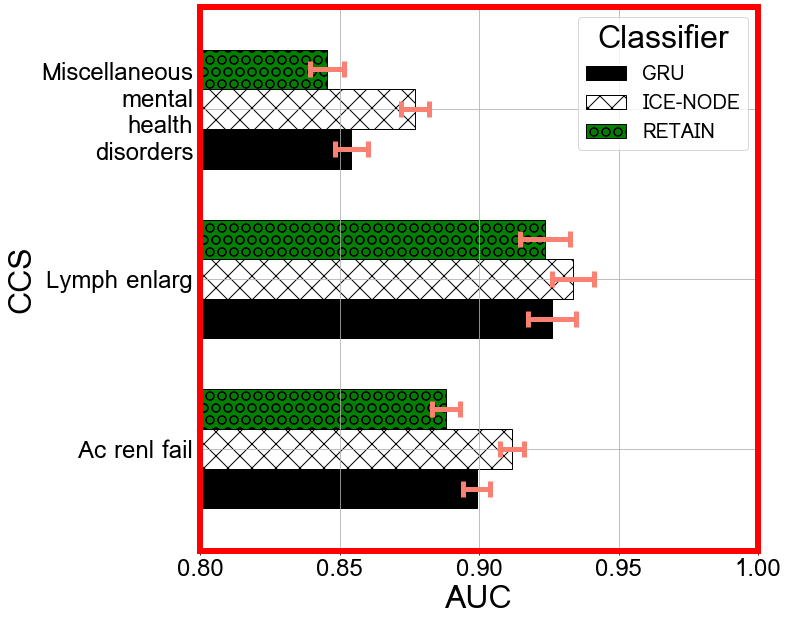

In [167]:
ax = selected_auc_barplot(upset_clfs, icenode_m4m3_excl)
current_figure = plt.gcf()
current_figure.savefig("icenode_m4m3.pdf", bbox_inches='tight')
plt.show()


## AUC Distribution

In [ ]:
import numpy as np
df = common_perf[['AUC(ICENODE)', 'DESC', 'VAR[AUC(ICENODE)]']].sort_values('AUC(ICENODE)')
df = df[df['AUC(ICENODE)'] > 0.65]
df.columns = ['AUC', 'CCS', 'VAR']
error = df['VAR'].apply(np.sqrt)

In [ ]:
len(df)

In [ ]:
fig, ax = plt.subplots(figsize=(8,20))
sns.set_theme()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

ax = sns.barplot(x="AUC", y="CCS", color="salmon", xerr=error*1,capsize=.2, data=df)
# plt.title('ICE-NODE AUC on CCS Codes of Comparable AUC with GRU/RETAIN', fontsize=20)

fig.tight_layout(pad=4)
plt.xlabel('AUC', fontsize=24)
plt.xlim(0.65, 1.0)
plt.xticks(fontsize=20)

plt.ylabel('CCS', fontsize=24)
plt.yticks(fontsize=14)

sns.despine(left=True)
ax.grid(True)
ax.tick_params(bottom=True, left=False)

current_figure = plt.gcf()
current_figure.savefig("common_performance.pdf")


plt.show()

In [ ]:
competing_df = []
comp_tests = competing_tests[competing_tests[[f'AUC({clf})' for clf in clfs]].max(axis=1) > 0.7]

for clf in clfs:
    comp_auc = comp_tests[f'AUC({clf})']
    comp_var = comp_tests[f'VAR[AUC({clf})]']
    comp_std = comp_var.apply(np.sqrt)
    comp_desc = comp_tests['DESC'].apply(lambda t: t if len(t) < 15 else t[:14] + '...')
    df = pd.DataFrame({'AUC': comp_auc, 'std': comp_std, 'CCS': comp_desc, 'Classifier': clf})
    df = df.sort_values('AUC').reset_index(drop=True)
    competing_df.append(df)

competing_df = pd.concat(competing_df)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 15))
sns.set_theme()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
colors = sns.xkcd_palette(["windows blue", "amber", "greyish"])

ax = sns.barplot(x="AUC", y="CCS", hue='Classifier', palette =colors , data=competing_df)
# plt.title('Performance of ICE-NODE/GRU/RETAIN', fontsize=40)

fig.tight_layout(pad=10)
plt.xlabel('AUC', fontsize=32)
plt.xlim(0.5, 1.0)
plt.xticks(fontsize=24)
plt.yticks(fontsize=14)

plt.ylabel('CCS', fontsize=36)
plt.legend(fontsize='xx-large', title_fontsize='40')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

sns.despine(left=True)
ax.grid(True)
ax.tick_params(bottom=True, left=False)
current_figure = plt.gcf()
current_figure.savefig("competing_performance.pdf")

plt.show()


## Generalization Across Datasets

In [ ]:


m4m3_acc20 = test_eval_table(results_m4m3, list(f'ACC-P{i}' for i in range(5)))
m4m3_acc20.to_csv(f'm4m3_acc20.csv')
print(m4m3_acc20.apply(lambda x: round(x, 3)).style.highlight_max(axis=0, props='bfseries: ;').to_latex())    

In [ ]:
m4_perf = pd.read_csv('acc20_M4.csv', index_col=[0]).loc[clfs_ordered,:]
m4_perf

In [ ]:
from matplotlib.colors import SymLogNorm, Normalize

diff = m4m3_acc20 - m4_perf
# display(diff)
sns.heatmap(diff, annot=True,  norm=SymLogNorm(linthresh=0.001, linscale=0.05,
                                              vmin=-0.1, vmax=0.1, base=2),  cmap='RdBu_r')

In [ ]:
results_m3m4.to_csv(f'evaltable_M3M4.csv')
results_m4m3.to_csv(f'evaltable_M4M3.csv')

In [ ]:
auctests_m3m4.to_csv(f'auctests_M3M4.csv')
auctests_m4m3.to_csv(f'auctests_M4M3.csv')

In [ ]:
# UpSet(upsetm3m4_df, subset_size='count', show_counts=True).plot()
# current_figure = plt.gcf()
# current_figure.savefig(f"upset_contents_M3M4.pdf")

In [ ]:
aucvals_m4m3 = auctests_m4m3.sort_values(by='N_POSITIVE_CODES')
aucvals_m4m3 = aucvals_m4m3.loc[:, tuple(f'AUC({clf})' for clf in clfs_ordered)+('CODE_INDEX', 'DESC','N_POSITIVE_CODES')].set_index('CODE_INDEX')
aucvals_m4m3

In [ ]:
aucvals_m4 = pd.read_csv('selected_auctests_M4.csv', index_col=[0])
aucvals_m4 = aucvals_m4[aucvals_m4['CODE_INDEX'].isin(aucvals_m4m3.index)].set_index('CODE_INDEX').iloc[aucvals_m4m3.index]
aucvals_m4

In [ ]:
code_desc = aucvals_m4m3['DESC']

In [ ]:
aucvalsonly_m4 = aucvals_m4.loc[:, tuple(f'AUC({clf})' for clf in clfs_ordered)]
aucvalsonly_m4.columns = clfs_ordered
aucvalsonly_m4

In [ ]:
aucvalsonly_m4m3 = aucvals_m4m3.loc[:, tuple(f'AUC({clf})' for clf in clfs_ordered)]
aucvalsonly_m4m3.columns = clfs_ordered
aucvalsonly_m4m3

In [ ]:
aucvals_diff = aucvalsonly_m4m3 - aucvalsonly_m4
aucvals_diff

In [ ]:
plt.figure(figsize=(10, 16))
sns.heatmap(aucvalsonly_m4m3,  linewidths=1, norm=SymLogNorm(linthresh=0.001, linscale=0.05,
                                              vmin=0.5, vmax=1., base=10),  cmap='RdBu_r')

## Trajectories for Patients with CCS codes best predicted with ICENODE

### Analyse AUC for Each Admission in the Test Partition

In [198]:
def admissions_auc_scores(model, test_ids):
    model, state = model
    return model.admissions_auc_scores(state, test_ids)

In [267]:
icenode_visit_auc_df = admissions_auc_scores(m4_predictors['ICE-NODE'], m4_test_ids)

In [268]:
icenode_visit_auc_df['N_VISITS'] = icenode_visit_auc_df['SUBJECT_ID'].apply(lambda i: (icenode_visit_auc_df['SUBJECT_ID'] == i).sum())
icenode_visit_auc_df

,SUBJECT_ID,HADM_ID,HADM_IDX,AUC,N_CODES,TIME,INTERVALS,LOS,R/T,NFE,N_VISITS
0,15661244,25538115,0,0.883,2.0,9.5,9.5,1.5,1.014794e-12,32.0,2
1,15661244,27008859,1,0.953,6.0,442.5,433.0,1.5,3.09197e-12,164.0,2
2,19794590,27666016,0,0.902,5.0,5.5,5.5,0.5,6.7801745e-12,20.0,8
3,19794590,25740118,1,0.894,6.0,243.5,238.0,5.5,3.7381326e-13,116.0,8
4,19794590,23237208,2,0.975,3.0,330.5,87.0,3.5,2.5855018e-13,74.0,8
...,...,...,...,...,...,...,...,...,...,...,...
27306,10477316,27328239,0,0.816,4.0,330.5,330.5,1.5,3.2235985e-12,140.0,1
27307,12098571,24506961,0,0.943,8.0,102.5,102.5,3.5,4.9574445e-13,74.0,4
27308,12098571,20433106,1,0.979,9.0,406.5,304.0,1.5,1.12310064e-13,122.0,4
27309,12098571,20553314,2,0.972,16.0,2439.5,2033.0,7.5,6.895149e-14,434.0,4


In [269]:
visit_auc_subject = icenode_visit_auc_df.groupby('SUBJECT_ID').agg({'AUC': 'mean', 'N_VISITS': 'max', 'N_CODES': ['min', 'max', 'mean', 'median'], 'INTERVALS': ['mean', 'max', 'min'], 'R/T': ['min', 'max', 'mean'] })


In [270]:
best_visit_auc_subjects =  visit_auc_subject[(visit_auc_subject.AUC['mean'] > 0.9) & (visit_auc_subject.N_VISITS['max'] > 1) & (visit_auc_subject.N_VISITS['max'] <10) & (visit_auc_subject.INTERVALS['max'] < 90)]
best_visit_auc_subjects

AUC N_VISITS N_CODES                      INTERVALS              \
             mean      max     min   max    mean median      mean   max   min   
SUBJECT_ID                                                                      
10018862    0.930        6    13.0  18.0  15.500   15.0    33.917  76.5  14.0   
10019596    0.940        2     4.0   7.0   5.500    5.5    33.250  46.5  20.0   
10041381    0.990        2     6.0   9.0   7.500    7.5    21.750  23.5  20.0   
10058750    0.971        3     4.0   6.0   5.000    5.0    33.167  49.5  22.0   
10071403    0.948        2     8.0  17.0  12.500   12.5    28.750  33.0  24.5   
...           ...      ...     ...   ...     ...    ...       ...   ...   ...   
19944092    0.942        2     5.0   9.0   7.000    7.0    33.750  46.0  21.5   
19957540    0.945        2    13.0  17.0  15.000   15.0    50.250  70.0  30.5   
19973934    0.916        3     3.0   6.0   4.333    4.0    40.167  84.0   3.0   
19986341    0.977        4    10.0  16.0  13.000   13.0    26.375  36.0  20.5   
19995080    0.923        2     5.0   7.0   6.000    6.0    35.250  40.0  30.5   

                      R/T                            
                      min            max       mean  
SUBJECT_ID                                           
10018862    3.1488965e-14   6.996075e-11  2.197e-11  
10019596    7.0410355e-13   3.080422e-12  1.892e-12  
10041381    2.2410138e-12   5.318445e-12  3.780e-12  
10058750     1.116988e-12  6.0333305e-12  3.903e-12  
10071403    1.0392891e-13  2.3219453e-13  1.681e-13  
...                   ...            ...        ...  
19944092    1.0159808e-13  2.6423423e-12  1.372e-12  
19957540     2.694774e-12   6.684778e-12  4.690e-12  
19973934    1.9602562e-12  5.4396787e-12  4.149e-12  
19986341    3.0145076e-14   7.482631e-12  2.668e-12  
19995080    3.3790118e-13  3.2113455e-12  1.775e-12  

[475 rows x 12 columns]

In [271]:
ccs_history = {i: m4_interface[clfs[0]].diag_flatccs_history(i)[1] for i in best_visit_auc_subjects.index}

In [272]:
ccs_history_icenode_best = {i: history for i, history in ccs_history.items() if len(set(history) & selected_icenode_m4_excl)> 0}

In [273]:
ccs_history_icenode_best

{}

In [274]:
len(ccs_history_icenode_best)

0

In [275]:
icenode, icenode_state = m4_predictors['ICE-NODE']
trajectory = icenode.sample_trajectory(icenode_state, ccs_history_icenode_best.keys(), 1)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
ccs_index = list(selected_icenode_m4_excl)
flatccs_idx2code = {idx: code for code, idx in m4_interface[clfs[0]].diag_flatccs_idx.items()}
idx2desc = lambda idx: m4_interface[clfs[0]].dag.diag_flatccs_desc[flatccs_idx2code[idx]]
ccs_description = list(map(idx2desc, ccs_index))


In [ ]:
data = {}
for i, traj in trajectory.items():
    diag_times = m4_interface[clfs[0]].diag_times(i)
    
    t = traj['t']
    d = traj['d']
    
    prob = []
    time = []
    code = []
    
    for ccs_desc, ccs_idx in zip(ccs_description, ccs_index):
        time.append(t)
        code.extend([ccs_desc]*len(t))
        prob.append(d[:, ccs_idx])

    prob = np.hstack(prob)
    time = np.hstack(time)
    
    
    df = pd.DataFrame({'t': time, r'$\hat{v}$': prob, 'code': code})
    data[i] = (df, diag_times)
    

In [ ]:
plt.rcParams['figure.figsize']=(10,10)
import math
for i, (df, diag_times) in data.items():

    plt.figure(i)
    
    g = sns.lineplot(data=df, x="t", y=r'$\hat{v}$', hue='code', marker='o')
    for diag_time in diag_times:
        g.axvline(x=diag_time, ymin=0, ymax=1, c="red", ls='--', linewidth=0.8, zorder=0, clip_on=False)

It seems that we cannot catch the smoothness of the trajectory as it evolves very quickly to the saturation value.